## Project: Building a Traffic Sign Recognition Classifier

## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
X_train.shape

(34799, 32, 32, 3)

### Providing a Basic Summary of the Data Set Using Python and Pandas

In [3]:
#Number of training examples
n_train = X_train.shape[0]

#Number of validation examples
n_validation = X_valid.shape[0]

#Number of testing examples.
n_test = X_test.shape[0]

#Shape of an traffic sign image?
image_shape = format(X_train[0].shape)

#How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

### Pre-processing the Data Set (normalization)

<b> Using normal pre-processing technique, I only normalized my dataset. When I tried to grayscale my image, the accuracy of my 
dataset was reduced by a margin of around 5 - 7 percent. Therefore, I decided to only normalize the images and not convert it 
to grayscale. <b>

38


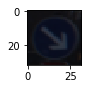

In [5]:
import random
import numpy as np

#X_train = np.array(X_train - 128.) / 256

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize = (1,1))
plt.imshow(image)
print(y_train[index])


### Model Architecture

In [6]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [7]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #Activation.
    conv1 = tf.nn.relu(conv1)

    #Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    #Activation.
    conv2 = tf.nn.relu(conv2)

    #Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 1, 1, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)

    #Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    #Activation.
    fc1    = tf.nn.relu(fc1)

    #Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    #Activation.
    fc2    = tf.nn.relu(fc2)
    
    #Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

In [8]:
import tensorflow as tf
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
EPOCHS = 30
BATCH_SIZE = 128
one_hot_y = tf.one_hot(y, 43)

In [9]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [10]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict = {x:batch_x, y:batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

<b> Below are the 5 images that I randomly downloaded from the internet: <b>

In [11]:
from scipy.misc import imread
im1 = imread("construction.jpg").astype(np.float32)
#im1 = im1 - np.mean(im1)
#im3 = np.array(im3 - 128.) / 256

im2 = imread("yield.jpg").astype(np.float32)
#im2 = im2 - np.mean(im2)
#im1 = np.array(im1 - 128.) / 256

im3 = imread("stop.jpg").astype(np.float32)
#im3 = im3 - np.mean(im3)
#im4 = np.array(im4 - 128.) / 256

im4 = imread("no_entry.jpg").astype(np.float32)
#im4 = im4 - np.mean(im4)
#im5 = np.array(im5 - 128.) / 256

im5 = imread("bumpy.jpg").astype(np.float32)
#im5 = im5 - np.mean(im5)
#im2 = np.array(im2 - 128.) / 256


C:\Users\Karan\Anaconda2\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\Karan\Anaconda2\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\Karan\Anaconda2\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Karan\Anaconda2\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\Users\Karan\

In [12]:
import scipy.misc
im1 = scipy.misc.imresize(im1, (32, 32))
im2 = scipy.misc.imresize(im2, (32, 32))
im3 = scipy.misc.imresize(im3, (32, 32))
im4 = scipy.misc.imresize(im4, (32, 32))
im5 = scipy.misc.imresize(im5, (32, 32))

C:\Users\Karan\Anaconda2\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  
C:\Users\Karan\Anaconda2\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Karan\Anaconda2\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.
C:\Users\Karan\Anaconda2\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` i

In [13]:
import time
import pandas as pd
sign_names = pd.read_csv('signnames.csv')
t = time.time()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x:batch_x, y:batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {}...".format(i+1))
        print("Validation Accuracy : {:.3f}".format(validation_accuracy))
        print()
    
    predict = tf.argmax(logits, 1)
    #preds = sess.run(predict, feed_dict={x: [im1, im2, im3, im4, im5]})
    probs = tf.nn.softmax(logits)
    output = sess.run(probs, feed_dict={x: [im1, im2, im3, im4, im5]})

# Print Output
    for input_im_ind in range(output.shape[0]):
        inds = np.argsort(output)[input_im_ind, :]
        print("Image", input_im_ind)
        for i in range(5):
            print("%s: %.3f" % (sign_names.ix[inds[-1 - i]][1], output[input_im_ind, inds[-1 - i]]))
        print()

    print("Time: %.3f seconds" % (time.time() - t))

Training...

EPOCH 1...
Validation Accuracy : 0.766

EPOCH 2...
Validation Accuracy : 0.831

EPOCH 3...
Validation Accuracy : 0.862

EPOCH 4...
Validation Accuracy : 0.861

EPOCH 5...
Validation Accuracy : 0.879

EPOCH 6...
Validation Accuracy : 0.883

EPOCH 7...
Validation Accuracy : 0.883

EPOCH 8...
Validation Accuracy : 0.873

EPOCH 9...
Validation Accuracy : 0.871

EPOCH 10...
Validation Accuracy : 0.887

EPOCH 11...
Validation Accuracy : 0.885

EPOCH 12...
Validation Accuracy : 0.895

EPOCH 13...
Validation Accuracy : 0.896

EPOCH 14...
Validation Accuracy : 0.898

EPOCH 15...
Validation Accuracy : 0.905

EPOCH 16...
Validation Accuracy : 0.878

EPOCH 17...
Validation Accuracy : 0.890

EPOCH 18...
Validation Accuracy : 0.898

EPOCH 19...
Validation Accuracy : 0.901

EPOCH 20...
Validation Accuracy : 0.908

EPOCH 21...
Validation Accuracy : 0.911

EPOCH 22...
Validation Accuracy : 0.906

EPOCH 23...
Validation Accuracy : 0.901

EPOCH 24...
Validation Accuracy : 0.915

EPOCH 25...


C:\Users\Karan\Anaconda2\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


### Analyzing the test Images

I was actually stuck when the Tensorflow session that I created ended as soon as the function ended. So the easy way out that I could figure out was to just use the same function when the session is still running and hence 4/5 images were correctly classified. I was actually pretty satisfied with results from the test data with only 5 images.